In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import warnings
warnings.filterwarnings('ignore')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))


# data visualization
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns



/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


In [2]:
# Load the trainng and data sets
train_df = pd.read_csv("/kaggle/input/titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/titanic/test.csv")

#shuffle the training data
train_df = train_df.reindex(np.random.permutation(train_df.index))

train_df.head()

# merge train and test data for common data processingg
data = pd.concat([train_df, test_df], axis=0, ignore_index=True)

# Storing Passenger Id for submission
Id = test_df.PassengerId

# **Data Visualisation**

In [3]:
train_df.shape

(891, 12)

In [4]:
test_df.shape

(418, 11)

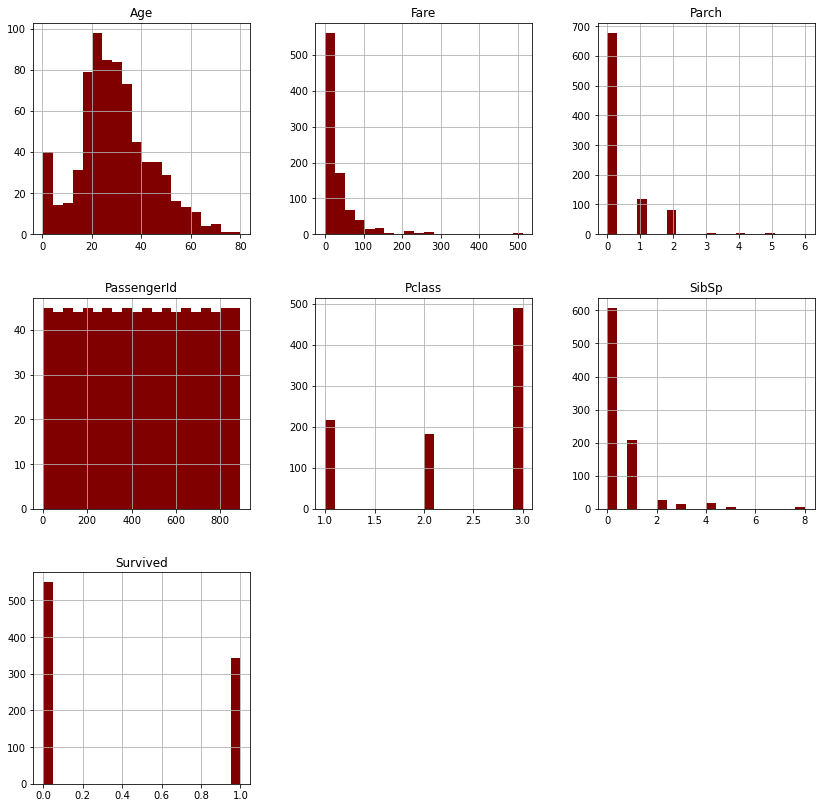

In [5]:
train_df.hist(figsize=(14,14), color='maroon', bins=20)
plt.show()

In [6]:
# Look at columns in order of percentage missing values 
data.isnull().mean().sort_values(ascending=False)

Cabin          0.774637
Survived       0.319328
Age            0.200917
Embarked       0.001528
Fare           0.000764
Ticket         0.000000
Parch          0.000000
SibSp          0.000000
Sex            0.000000
Name           0.000000
Pclass         0.000000
PassengerId    0.000000
dtype: float64

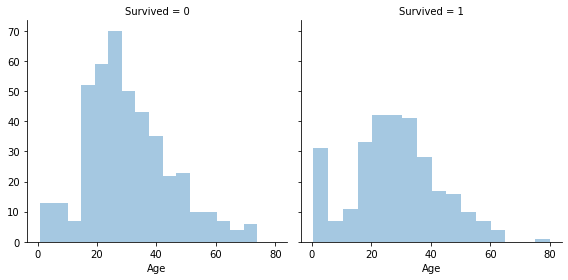

In [7]:
# Explore Age histogram for NotSurvived/Survived (0/1)
plot = sns.FacetGrid(train_df, col='Survived', height=4).map(sns.distplot, "Age", kde=False)

**Age**

Create new classification for Age bins


In [8]:
# extracting the Title (which always ends with a ".")
for name_string in data['Name']:
    data['Title'] = data['Name'].str.extract('([A-Za-z]+)\.', expand=True)

#transform titles which are synonyms
data['Title']=data['Title'].replace({'Ms':'Miss','Mlle':'Miss','Mme':'Mrs'})

data['Title'].value_counts()

Mr          757
Miss        264
Mrs         198
Master       61
Rev           8
Dr            8
Col           4
Major         2
Lady          1
Capt          1
Jonkheer      1
Don           1
Countess      1
Sir           1
Dona          1
Name: Title, dtype: int64

In [9]:
# Add new column to denote if passenger has cabin or not
data["hasCabin"] = data["Cabin"].notnull().astype('int')

# Add column to denote if first character of ticket is an 'A' (low survival rate)
#data['a_ticket'] = np.where(data['Ticket'].astype(str).str[0] == 'A', 1, 0)



Need to narrow down this titles

In [10]:
# Posh passengers
data['Title'] = data['Title'].replace(['Sir','Don','Dona','Jonkheer','Lady','Countess'], 'Posh')

# passengers with a higher social standing
data['Title']=data['Title'].replace(['Dr', 'Rev','Col','Major','Capt'], 'Hoi Polloi')

data['Title'].value_counts()

Mr            757
Miss          264
Mrs           198
Master         61
Hoi Polloi     23
Posh            6
Name: Title, dtype: int64

In [11]:
title_list=data.groupby('Title')['Age'].median().index.to_list()

# Filling missing age values 
for title in title_list:
    if title=='Miss':
        # Miss with Parch = 0 and missing age value: set median age >15 to missing values
        data.loc[(data['Age'].isnull()) & (data['Title'] == title) & (data['Parch'] == 0), 'Age'] \
        = data['Age'][(data['Title']== title) & (data['Age']>=15)].median()
        
        # Miss with Parch > 0 and missing age value: set median age <15 to missing values
        data.loc[(data['Age'].isnull()) & (data['Title'] == title) & (data['Parch'] > 0), 'Age'] \
        = data['Age'][(data['Title']== title) & (data['Age']<15)].median()
        
        # all Misses with Age < 15: set Title to youngMiss 
        data.loc[(data['Age']<15) & (data['Title'] == title), 'Title'] \
        = 'Little Miss'    
                                                 
    else: 
        data.loc[(data['Age'].isnull()) & (data['Title'] == title), 'Age'] \
        = data['Age'][(data['Title']== title)].median()

data['Title'].value_counts()

Mr             757
Miss           204
Mrs            198
Master          61
Little Miss     60
Hoi Polloi      23
Posh             6
Name: Title, dtype: int64

In [12]:
# We split the feature Age in five categories, where category 1 refers to children (age<15)
data["AgeCat"]= pd.cut(data["Age"], bins=[0,14.9,19.9,30,45,60,max(data["Age"]+1)], labels=['1','2','3','4','5','6'])

# size of each category
data['AgeCat'].value_counts()

3    601
4    309
1    127
5    123
2    116
6     33
Name: AgeCat, dtype: int64

In [13]:
# create feature FamilySize
data.loc[data['SibSp'] + data['Parch'] + 1 == 1, 'FamilySize'] = 'Single'
data.loc[data['SibSp'] + data['Parch'] + 1 > 1 , 'FamilySize'] = 'Small'
data.loc[data['SibSp'] + data['Parch'] + 1 > 4 , 'FamilySize'] = 'Big'

In [14]:
# extract last names
#data['Last_Name'] = data['Name'].apply(lambda x: str.split(x, ",")[0])
data['Last_Name'] =  data['Name'].str.extract('([A-Za-z]+),', expand=True)
data['Last_Name'].value_counts()
#data.groupby('Last_Name')

Sage         11
Andersson    11
Goodwin       8
Asplund       8
Davies        7
             ..
Knight        1
Mannion       1
Saalfeld      1
Maenpaa       1
Horgan        1
Name: Last_Name, Length: 872, dtype: int64

In [15]:
data['Last_Name'] = data['Name'].apply(lambda x: str.split(x, ",")[0])
default_value = 0.5

data['FamilySurvival'] = default_value
for grp, grp_df in data[['Survived', 'Last_Name', 'Ticket', 'PassengerId']].groupby(['Last_Name']):
    
    if (len(grp_df) != 1):
        # A Family group is found.
        for ind, row in grp_df.iterrows():
            smax = grp_df.drop(ind)['Survived'].max()
            smin = grp_df.drop(ind)['Survived'].min()
            passID = row['PassengerId']
            if (smax == 1.0):
                data.loc[data['PassengerId'] == passID, 'FamilySurvival'] = 1
            elif (smin == 0.0):
                data.loc[data['PassengerId'] == passID, 'FamilySurvival'] = 0
for _, grp_df in data.groupby('Ticket'):
    if (len(grp_df) != 1):
        #print(grp_df)
        for ind, row in grp_df.iterrows():
            if (row['FamilySurvival'] == 0) | (row['FamilySurvival']== 0.5):
                smax = grp_df.drop(ind)['Survived'].max()
                smin = grp_df.drop(ind)['Survived'].min()
                passID = row['PassengerId']
                if (smax == 1.0):
                    data.loc[data['PassengerId'] == passID, 'FamilySurvival'] = 1
                elif (smin == 0.0):
                    data.loc[data['PassengerId'] == passID, 'FamilySurvival'] = 0

# check number of passengers in the different categories
data['FamilySurvival'].value_counts() 

0.5    656
1.0    376
0.0    277
Name: FamilySurvival, dtype: int64

In [16]:
# Correct Fare per person
data['FareCorr'] = data['Fare'].copy()

for grp, grp_df in data[['Ticket','Name', 'Pclass', 'Fare', 'PassengerId']].groupby(['Ticket']):

    if (len(grp_df) != 1):
        for ind, row in grp_df.iterrows():
            passID = row['PassengerId']
            data.loc[data['PassengerId'] == passID, 'FareCorr'] = data['Fare'][data['PassengerId'] == passID]/len(grp_df)
# Replacing one missing Fare value
fa = data[data["Pclass"] == 3]
data['FareCorr'].fillna(fa['FareCorr'].median(), inplace = True)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1309 entries, 0 to 1308
Data columns (total 19 columns):
 #   Column          Non-Null Count  Dtype   
---  ------          --------------  -----   
 0   PassengerId     1309 non-null   int64   
 1   Survived        891 non-null    float64 
 2   Pclass          1309 non-null   int64   
 3   Name            1309 non-null   object  
 4   Sex             1309 non-null   object  
 5   Age             1309 non-null   float64 
 6   SibSp           1309 non-null   int64   
 7   Parch           1309 non-null   int64   
 8   Ticket          1309 non-null   object  
 9   Fare            1308 non-null   float64 
 10  Cabin           295 non-null    object  
 11  Embarked        1307 non-null   object  
 12  Title           1309 non-null   object  
 13  hasCabin        1309 non-null   int64   
 14  AgeCat          1309 non-null   category
 15  FamilySize      1309 non-null   object  
 16  Last_Name       1309 non-null   object  
 17  FamilySurvival

In [17]:
data['FareCat']=pd.qcut(data['FareCorr'], 7, labels=['1','2','3','4','5','6','7'])
data['FareCat'].value_counts()

2    236
5    212
1    188
7    186
4    167
6    162
3    158
Name: FareCat, dtype: int64

In [18]:
data['Embarked'].fillna('C', inplace = True)
data[data['Embarked'].isnull()]

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,hasCabin,AgeCat,FamilySize,Last_Name,FamilySurvival,FareCorr,FareCat


In [19]:
# Convert cabin into numeric
data.Cabin.fillna('9', inplace=True)
#data['Cabin'].replace('0', 9, inplace=True)
data.loc[data.Cabin.str[0] == 'A', 'Cabin'] = 1
data.loc[data.Cabin.str[0] == 'B', 'Cabin'] = 2
data.loc[data.Cabin.str[0] == 'C', 'Cabin'] = 3
data.loc[data.Cabin.str[0] == 'D', 'Cabin'] = 4
data.loc[data.Cabin.str[0] == 'E', 'Cabin'] = 5
data.loc[data.Cabin.str[0] == 'F', 'Cabin'] = 6
data.loc[data.Cabin.str[0] == 'G', 'Cabin'] = 7
data.loc[data.Cabin.str[0] == 'T', 'Cabin'] = 8


# Convert Sex to numeric
data['Sex'].replace('female', 1, inplace=True)
data['Sex'].replace('male', 2, inplace=True)

# Convert Embarked to numeric
data['Embarked'].replace('S', 1, inplace=True)
data['Embarked'].replace('C', 2, inplace=True)
data['Embarked'].replace('Q', 3, inplace=True)

# Convert Family Size to numeric
data['FamilySize'].replace('Single', 1, inplace=True)
data['FamilySize'].replace('Small', 2, inplace=True)
data['FamilySize'].replace('Big', 3, inplace=True)

# Convert Title to numeric
data['Title'].replace('Mrs', 1, inplace=True)
data['Title'].replace('Mr', 2, inplace=True)
data['Title'].replace('Miss', 3, inplace=True)
data['Title'].replace('Posh', 4, inplace=True)
data['Title'].replace('Hoi Polloi', 5, inplace=True)
data['Title'].replace('Little Miss', 6, inplace=True)
data['Title'].replace('Master', 7, inplace=True)
                      
                      
data['Title'].value_counts()

data.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Title,hasCabin,AgeCat,FamilySize,Last_Name,FamilySurvival,FareCorr,FareCat
0,84,0.0,1,"Carrau, Mr. Francisco M",2,28.0,0,0,113059,47.1000,9,1,2,0,3,1,Carrau,0.5,23.5500,6
1,795,0.0,3,"Dantcheff, Mr. Ristiu",2,25.0,0,0,349203,7.8958,9,1,2,0,3,1,Dantcheff,0.5,7.8958,3
2,27,0.0,3,"Emir, Mr. Farred Chehab",2,29.0,0,0,2631,7.2250,9,2,2,0,3,1,Emir,0.5,7.2250,2
3,545,0.0,1,"Douglas, Mr. Walter Donald",2,50.0,1,0,PC 17761,106.4250,3,2,2,1,5,2,Douglas,1.0,35.4750,7
4,481,0.0,3,"Goodwin, Master. Harold Victor",2,9.0,5,2,CA 2144,46.9000,9,1,7,0,1,3,Goodwin,0.0,5.8625,1


In [20]:
data_pre = data.drop(['PassengerId','Name','Age','Parch','SibSp','Ticket','Fare','Last_Name','FareCorr'],axis=1)

In [21]:
# Splitting dataset into train
train = data_pre[:len(train_df)]

# Splitting dataset into test
test = data_pre[len(train_df):]

# Drop labels 'Survived' because there shouldn't be a Survived column in the test data
test.drop(labels=['Survived'], axis=1, inplace=True)

In [22]:
test.head()

,Pclass,Sex,Cabin,Embarked,Title,hasCabin,AgeCat,FamilySize,FamilySurvival,FareCat
891,3,2,9,3,2,0,4,1,1.0,3
892,3,1,9,1,1,0,5,2,0.5,1
893,2,2,9,3,2,0,6,1,0.5,5
894,3,2,9,1,2,0,3,1,0.5,4
895,3,1,9,1,1,0,3,2,1.0,1


In [23]:
# load up train/validation set! 
train_size = int(train.shape[0] * 0.85)

train_dataset = train[:train_size]
val_dataset = train[train_size:]

X_train = train_dataset.drop(labels=["Survived"], axis=1).values
Y_train = train_dataset["Survived"].values

X_val = val_dataset.drop(labels=["Survived"], axis=1).values
Y_val = val_dataset["Survived"].values

input_size = len(train_dataset.columns) - 1  # number of final features 

In [24]:
print("x_train shape",X_train.shape)
print("x_val shape",X_val.shape)
print("y_train shape",Y_train.shape)
print("y_val shape",Y_val.shape)


x_train shape (757, 10)
x_val shape (134, 10)
y_train shape (757,)
y_val shape (134,)


In [25]:
from collections import Counter
from statistics import mode
from sklearn.model_selection import KFold
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier, VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV, cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, StandardScaler
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import GradientBoostingRegressor

In [26]:
# Our final model
#final_model = RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
#                       criterion='gini', max_depth=12, max_features='auto',
#                       max_leaf_nodes=None, max_samples=None,
#                       min_impurity_decrease=0.0, min_impurity_split=None,
#                       min_samples_leaf=1, min_samples_split=5,
#                       min_weight_fraction_leaf=0.0, n_estimators=200,
#                       n_jobs=None, oob_score=False, random_state=None,
#                       verbose=0, warm_start=False)



# Train final_model with train data
#final_model.fit(X_train, Y_train)

# Predict final_model
#predictions = final_model.predict(X_val)

# Print out score
#print('Accuracy: ', accuracy_score(predictions, Y_val))

In [27]:
# Final predictions against test passenger ID for GradientBoost model

#final_predictions = final_model.predict(test)

#output = pd.DataFrame({'PassengerId': Id, 'Survived':final_predictions})
#output.to_csv('submission.csv', index=False)
#print('Done')

In [28]:
# Not all datatypes are numeric
train.dtypes

Survived           float64
Pclass               int64
Sex                  int64
Cabin               object
Embarked             int64
Title                int64
hasCabin             int64
AgeCat            category
FamilySize           int64
FamilySurvival     float64
FareCat           category
dtype: object

In [29]:
train["Cabin"] = pd.to_numeric(train["Cabin"])
train["AgeCat"] = pd.to_numeric(train["AgeCat"])
train["FareCat"] = pd.to_numeric(train["FareCat"])

test["Cabin"] = pd.to_numeric(test["Cabin"])
test["AgeCat"] = pd.to_numeric(test["AgeCat"])
test["FareCat"] = pd.to_numeric(test["FareCat"])

In [30]:
train.dtypes

Survived          float64
Pclass              int64
Sex                 int64
Cabin               int64
Embarked            int64
Title               int64
hasCabin            int64
AgeCat              int64
FamilySize          int64
FamilySurvival    float64
FareCat             int64
dtype: object

In [31]:
# Split valid test data

from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split

def split_valid_test(data, fraction = (1 - 0.8)):
    lb = LabelBinarizer()
    data_y = data['Survived']
    data_y = lb.fit_transform(data_y)
    data_x = data.drop(['Survived'], axis = 1)
    train_x, valid_x, train_y, valid_y = train_test_split(data_x, data_y, test_size = fraction)
    return train_x.values, valid_x, train_y, valid_y

X_train, X_val, Y_train, Y_val = split_valid_test(train)

In [32]:
# Implement neural network

import tensorflow as tf

model = tf.keras.Sequential([ 
    tf.keras.layers.Dense(64, 
                          kernel_initializer = 'glorot_normal', 
                          #bias_initializer = 'truncated_normal', 
                          kernel_regularizer = tf.keras.regularizers.l2(0.001), 
                          bias_regularizer = tf.keras.regularizers.l2(0.01), 
                          activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(32, 
                          kernel_initializer = 'glorot_normal',
                          #bias_initializer = 'truncated_normal', 
                          kernel_regularizer = tf.keras.regularizers.l2(0.001), 
                          bias_regularizer = tf.keras.regularizers.l2(0.01), 
                          activation = 'relu'),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(16, 
                          kernel_initializer = 'glorot_normal',
                          #bias_initializer = 'truncated_normal', 
                          kernel_regularizer = tf.keras.regularizers.l2(0.001), 
                          bias_regularizer = tf.keras.regularizers.l2(0.01), 
                          activation = 'relu'),
    #tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(1, 
                          kernel_initializer = 'glorot_normal', 
                          #bias_initializer = 'truncated_normal', 
                          kernel_regularizer = tf.keras.regularizers.l2(0.001), 
                          bias_regularizer = tf.keras.regularizers.l2(0.01), 
                          activation = 'sigmoid')
])

model.compile(optimizer='adam', 
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True), 
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=200, validation_data=(X_val, Y_val))

Epoch 1/200
23/23 [==============================] - 0s 14ms/step - loss: 0.7795 - accuracy: 0.5969 - val_loss: 0.7681 - val_accuracy: 0.6760
Epoch 2/200
23/23 [==============================] - 0s 4ms/step - loss: 0.7634 - accuracy: 0.6025 - val_loss: 0.7592 - val_accuracy: 0.6760
Epoch 3/200
23/23 [==============================] - 0s 4ms/step - loss: 0.7496 - accuracy: 0.6124 - val_loss: 0.7582 - val_accuracy: 0.7039
Epoch 4/200
23/23 [==============================] - 0s 4ms/step - loss: 0.7383 - accuracy: 0.6573 - val_loss: 0.7530 - val_accuracy: 0.7039
Epoch 5/200
23/23 [==============================] - 0s 4ms/step - loss: 0.7299 - accuracy: 0.6685 - val_loss: 0.7521 - val_accuracy: 0.6983
Epoch 6/200
23/23 [==============================] - 0s 4ms/step - loss: 0.7216 - accuracy: 0.6924 - val_loss: 0.7499 - val_accuracy: 0.6927
Epoch 7/200
23/23 [==============================] - 0s 4ms/step - loss: 0.7158 - accuracy: 0.6952 - val_loss: 0.7442 - val_accuracy: 0.7039
Epoch 8/200


Epoch 59/200
23/23 [==============================] - 0s 4ms/step - loss: 0.6536 - accuracy: 0.7893 - val_loss: 0.6693 - val_accuracy: 0.8156
Epoch 60/200
23/23 [==============================] - 0s 4ms/step - loss: 0.6503 - accuracy: 0.8076 - val_loss: 0.6680 - val_accuracy: 0.8156
Epoch 61/200
23/23 [==============================] - 0s 4ms/step - loss: 0.6508 - accuracy: 0.7978 - val_loss: 0.6660 - val_accuracy: 0.8212
Epoch 62/200
23/23 [==============================] - 0s 4ms/step - loss: 0.6565 - accuracy: 0.7767 - val_loss: 0.6710 - val_accuracy: 0.8268
Epoch 63/200
23/23 [==============================] - 0s 4ms/step - loss: 0.6514 - accuracy: 0.8034 - val_loss: 0.6711 - val_accuracy: 0.8324
Epoch 64/200
23/23 [==============================] - 0s 4ms/step - loss: 0.6518 - accuracy: 0.7921 - val_loss: 0.6746 - val_accuracy: 0.8101
Epoch 65/200
23/23 [==============================] - 0s 5ms/step - loss: 0.6529 - accuracy: 0.7837 - val_loss: 0.6686 - val_accuracy: 0.8268
Epoch 

23/23 [==============================] - 0s 4ms/step - loss: 0.6435 - accuracy: 0.8258 - val_loss: 0.6711 - val_accuracy: 0.7933
Epoch 117/200
23/23 [==============================] - 0s 4ms/step - loss: 0.6477 - accuracy: 0.8020 - val_loss: 0.6696 - val_accuracy: 0.8212
Epoch 118/200
23/23 [==============================] - 0s 4ms/step - loss: 0.6479 - accuracy: 0.7921 - val_loss: 0.6621 - val_accuracy: 0.8547
Epoch 119/200
23/23 [==============================] - 0s 4ms/step - loss: 0.6429 - accuracy: 0.8216 - val_loss: 0.6688 - val_accuracy: 0.8324
Epoch 120/200
23/23 [==============================] - 0s 4ms/step - loss: 0.6407 - accuracy: 0.8160 - val_loss: 0.6654 - val_accuracy: 0.8324
Epoch 121/200
23/23 [==============================] - 0s 4ms/step - loss: 0.6405 - accuracy: 0.8258 - val_loss: 0.6681 - val_accuracy: 0.8101
Epoch 122/200
23/23 [==============================] - 0s 4ms/step - loss: 0.6445 - accuracy: 0.8048 - val_loss: 0.6796 - val_accuracy: 0.8156
Epoch 123/200

23/23 [==============================] - 0s 4ms/step - loss: 0.6407 - accuracy: 0.8244 - val_loss: 0.6616 - val_accuracy: 0.8436
Epoch 174/200
23/23 [==============================] - 0s 4ms/step - loss: 0.6398 - accuracy: 0.8174 - val_loss: 0.6584 - val_accuracy: 0.8547
Epoch 175/200
23/23 [==============================] - 0s 4ms/step - loss: 0.6414 - accuracy: 0.8244 - val_loss: 0.6602 - val_accuracy: 0.8380
Epoch 176/200
23/23 [==============================] - 0s 4ms/step - loss: 0.6370 - accuracy: 0.8258 - val_loss: 0.6689 - val_accuracy: 0.8212
Epoch 177/200
23/23 [==============================] - 0s 4ms/step - loss: 0.6438 - accuracy: 0.8132 - val_loss: 0.6594 - val_accuracy: 0.8436
Epoch 178/200
23/23 [==============================] - 0s 4ms/step - loss: 0.6430 - accuracy: 0.8132 - val_loss: 0.6595 - val_accuracy: 0.8492
Epoch 179/200
23/23 [==============================] - 0s 4ms/step - loss: 0.6418 - accuracy: 0.8118 - val_loss: 0.6656 - val_accuracy: 0.8268
Epoch 180/200

6/6 - 0s - loss: 0.6594 - accuracy: 0.8436

Test accuracy: 0.8435754179954529


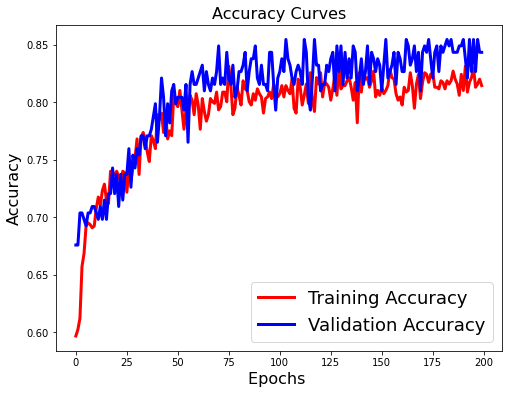

In [33]:
# Plot model accuracy

valid_loss, valid_acc = model.evaluate(X_val, Y_val, verbose=2)
print('\nTest accuracy:', valid_acc)

plt.figure(figsize = [8, 6])
plt.plot(history.history['accuracy'], 'r', linewidth = 3.0)
plt.plot(history.history['val_accuracy'], 'b', linewidth = 3.0)
plt.legend(['Training Accuracy', 'Validation Accuracy'], fontsize = 18)
plt.xlabel('Epochs ', fontsize = 16)
plt.ylabel('Accuracy', fontsize = 16)
plt.title('Accuracy Curves', fontsize = 16)
plt.show()

In [34]:
# Predict

predictions = model.predict(test)
predictions = np.where(predictions > 0.5, 1, 0)

# Create and download output file

data_to_submit = pd.DataFrame()
data_to_submit['PassengerId'] = Id
data_to_submit['Survived'] = pd.DataFrame(predictions)
data_to_submit.to_csv('submission.csv', header=True, index=False)

print("Your submission was successfully saved!")

Your submission was successfully saved!


In [35]:
data_to_submit.head()

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0


In [36]:
# Look at data for those with wrong predictions
prediction = np.round(model.predict(X_val))
#print(prediction)
wrong_predictions = X_val[prediction != Y_val]
#wrong_predictions["predicted"] = np.round(model.predict(X_val))
wrong_predictions

,Pclass,Sex,Cabin,Embarked,Title,hasCabin,AgeCat,FamilySize,FamilySurvival,FareCat
531,3,2,9,2,2,0,3,1,0.5,2
815,3,2,9,1,2,0,3,1,1.0,2
128,3,1,9,1,1,0,3,2,1.0,1
501,3,2,9,1,2,0,4,1,1.0,2
265,3,2,9,1,2,0,3,1,0.5,3
395,1,2,3,1,2,1,5,2,1.0,6
315,2,2,9,1,7,0,1,2,1.0,2
716,3,1,9,1,3,0,2,3,1.0,3
888,3,2,9,1,2,0,3,1,0.5,2
646,2,2,9,1,2,0,4,1,0.5,5
